Output directory set to: /content/AI Facial Skin Aging Detection
Mounting Google Drive...
Mounted at /content/drive
Google Drive Mounted Successfully.
Starting image loading and resizing...
Processing class: clear skin
Processing class: dark spots
Processing class: puffy eyes
Processing class: wrinkles

Images (X) shape: (1201, 224, 224, 3) (Range [0, 255])
Labels (y_encoded) shape: (1201, 4) (One-Hot Encoded)

Data saved to: /content/AI Facial Skin Aging Detection/X_data_224_rgb.npy


/tmp/ipython-input-2652691634.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.countplot(x=label_names, palette="viridis")


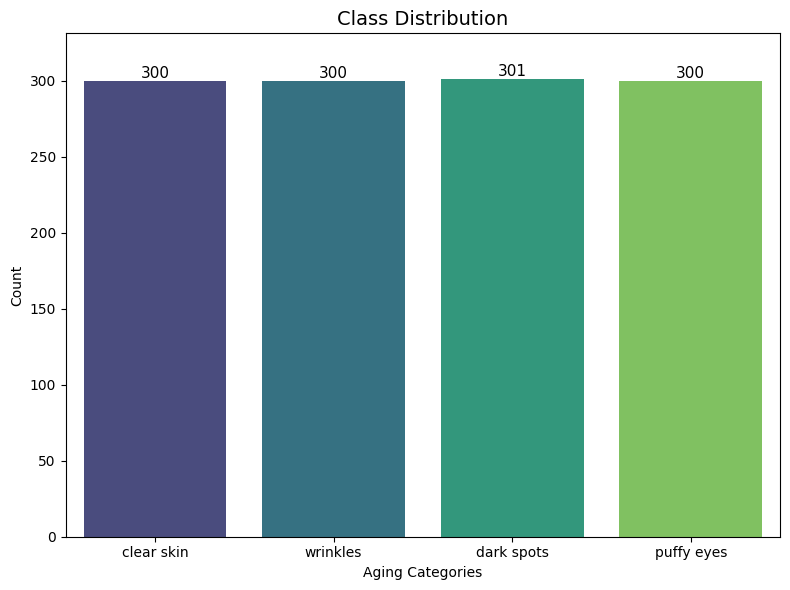


--- Preprocessing Complete ---


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle # Import shuffle function
from tensorflow.keras.utils import to_categorical # Import to_categorical for one-hot encoding
from google.colab import drive
import seaborn as sns # Import seaborn for plotting

# --- Configuration ---
# NOTE: Using 'gdrive' as per your original file snippet. Colab often maps to 'gdrive' or 'drive'.
DRIVE_PATH = '/content/drive'
# **CRITICAL:** Ensure this path correctly points to your DATASET folder in Google Drive.
# Example path: MyDrive/FacialAgingProject/DATASET/
BASE_DIR = os.path.join(DRIVE_PATH, 'MyDrive', 'DATASET') # Corrected BASE_DIR path
OUTPUT_DIR = '/content/AI Facial Skin Aging Detection'
CLASSES = ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 224 # Standard input size for EfficientNetB0
BATCH_SIZE = 32
RANDOM_STATE = 42
VALIDATION_SPLIT = 0.2 # Use 20% of data for validation

# Ensure output directory exists for saving the model
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory set to: {OUTPUT_DIR}")

# --- Mount Drive ---
print("Mounting Google Drive...")
# This will prompt you to click a link and sign in.
drive.mount(DRIVE_PATH)
print("Google Drive Mounted Successfully.")
def load_images(data_dir, classes):
    """Loads images, resizes, and converts BGR to RGB."""
    data = []
    labels = []
    label_names_for_plot = []

    print("Starting image loading and resizing...")
    for idx, label in enumerate(classes):
        path = os.path.join(data_dir, label)
        if not os.path.exists(path):
            print(f"ERROR: Path not found: {path}")
            continue

        print(f"Processing class: {label}")
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Convert BGR (OpenCV default) to RGB (Matplotlib/TF default)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                # Append as float32 in [0, 255] range
                data.append(img.astype('float32'))
                labels.append(idx)
                label_names_for_plot.append(label)
            else:
                print(f"Warning: Could not read image {img_name}")

    return np.array(data), np.array(labels), label_names_for_plot

# --- Load and Process Data ---
X, y, label_names = load_images(BASE_DIR, CLASSES)

# Shuffle the data
X, y, label_names = shuffle(X, y, label_names, random_state=RANDOM_STATE)

# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(CLASSES))

print(f"\nImages (X) shape: {X.shape} (Range [0, 255])")
print(f"Labels (y_encoded) shape: {y_encoded.shape} (One-Hot Encoded)")

# --- Split data for training/validation in the next module ---
# Split here to ensure the original `X` and `y_encoded` match the shapes expected later
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

# --- Save .npy files (as per your original script) ---
X_data_path = os.path.join(OUTPUT_DIR, 'X_data_224_rgb.npy')
y_labels_path = os.path.join(OUTPUT_DIR, 'y_labels_one_hot.npy')
np.save(X_data_path, X)
np.save(y_labels_path, y_encoded)
print(f"\nData saved to: {X_data_path}")

# --- Visualize Class Distribution (Bar Graph) ---
plt.figure(figsize=(8, 6))
bars = sns.countplot(x=label_names, palette="viridis")
plt.title("Class Distribution", fontsize=14)
plt.xlabel("Aging Categories")
plt.ylabel("Count")
# Set ylim dynamically based on class counts
plt.ylim(0, max(np.bincount(y)) * 1.1)

# Annotate bars with exact counts
for bar in bars.patches:
    bars.annotate(f'{int(bar.get_height())}',
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='bottom', fontsize=11, color='black')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'class_distribution_plot.png'))
plt.show() # This displays the Class Distribution Bar Graph

print("\n--- Preprocessing Complete ---")

In [2]:
# ===========================================
# IMPORTS AND CONFIGURATION
# ===========================================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# --- Configuration ---
DRIVE_PATH = '/content/drive'
DATA_PATH = os.path.join(DRIVE_PATH, '/content/drive/MyDrive/DATASET')
MODEL_PATH = os.path.join(DATA_PATH, 'final_efficientnet_model1.keras') # Changed to .keras
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 224
RANDOM_STATE = 42

# --- Hyperparameters ---
INITIAL_LR = 1e-3
FINE_TUNE_LR = 1e-5
BATCH_SIZE = 16
EPOCHS_STAGE1 = 40   # Initial training
EPOCHS_STAGE2 = 40   # Fine-tuning

# --- Mount Drive ---
print("🔗 Mounting Google Drive...")
drive.mount(DRIVE_PATH)

🔗 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#  LOAD PREPROCESSED DATA
# ===========================================
print(" Loading preprocessed dataset...")

try:
    X = np.load(os.path.join(OUTPUT_DIR, 'X_data_224_rgb.npy'))
    y_encoded = np.load(os.path.join(OUTPUT_DIR, 'y_labels_one_hot.npy'))
except FileNotFoundError:
    raise FileNotFoundError(" Data files not found. Run the preprocessing script first.")

X = X.astype('float32')  # Keep [0, 255] range
print(f" Data loaded. X shape: {X.shape}, y shape: {y_encoded.shape}")

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)
print(f" Dataset Split | Train: {X_train.shape}, Val: {X_val.shape}")

 Loading preprocessed dataset...
 Data loaded. X shape: (1201, 224, 224, 3), y shape: (1201, 4)
 Dataset Split | Train: (960, 224, 224, 3), Val: (241, 224, 224, 3)


In [4]:
y_train_labels = np.argmax(y_train, axis=1)
class_weights_val = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=y_train_labels)
class_weights = dict(enumerate(class_weights_val))
print(f"Class Weights: {class_weights}")

# --- Data Augmentation Generators ---
# Training: Augmentations ON
datagen_train = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation: No augmentations
datagen_val = ImageDataGenerator()

train_generator = datagen_train.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = datagen_val.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


In [5]:
#  BUILD MODEL FUNCTION
# ===========================================
def build_model(input_shape=(224, 224, 3), num_classes=4):
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    inputs = Input(shape=input_shape)
    x = preprocess_input(inputs)

    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
    base_model.trainable = False  # Stage 1: frozen

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model, base_model

model, base_model = build_model(num_classes=NUM_CLASSES)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
#  STAGE 1: TRAIN CLASSIFICATION HEAD
# ===========================================
print("\n--- Stage 1: Training Classification Head ---")

model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_stage1 = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(os.path.join(DATA_PATH, 'stage1_best1.keras'), # Changed to .keras
                    monitor='val_accuracy', save_best_only=True, verbose=1)
]

steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS_STAGE1,
    class_weight=class_weights,
    callbacks=callbacks_stage1,
    verbose=2
)


--- Stage 1: Training Classification Head ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40

Epoch 1: val_accuracy improved from -inf to 0.79167, saving model to /content/drive/MyDrive/DATASET/stage1_best1.keras
60/60 - 105s - 2s/step - accuracy: 0.6948 - loss: 0.8339 - val_accuracy: 0.7917 - val_loss: 0.5697
Epoch 2/40

Epoch 2: val_accuracy improved from 0.79167 to 0.81250, saving model to /content/drive/MyDrive/DATASET/stage1_best1.keras
60/60 - 141s - 2s/step - accuracy: 0.7781 - loss: 0.5791 - val_accuracy: 0.8125 - val_loss: 0.5280
Epoch 3/40

Epoch 3: val_accuracy did not improve from 0.81250
60/60 - 142s - 2s/step - accuracy: 0.8323 - loss: 0.4755 - val_accuracy: 0.7917 - val_loss: 0.5667
Epoch 4/40

Epoch 4: val_accuracy improved from 0.81250 to 0.82500, saving model to /content/drive/MyDrive/DATASET/stage1_best1.keras
60/60 - 89s - 1s/step - accuracy: 0.8469 - loss: 0.4771 - val_accuracy: 0.8250 - val_loss: 0.4839
Epoch 5/40

Epoch 5: val_accuracy improved from 0.82500 to 0.83333, saving model to /content/drive/MyDrive/DATASET/stage1_best1.keras
60/60 - 1

In [8]:
# ===========================================
# STAGE 2: FINE-TUNING
# ===========================================
print("\n--- Stage 2: Fine-tuning EfficientNet Layers ---")

# Load the best weights from Stage 1 to continue training.
# The best model from Stage 1 was saved as 'stage1_best1.keras'.
# If a previous (potentially interrupted) Stage 2 run saved to MODEL_PATH, it would be loaded here.
# First, ensure the model has the architecture to load weights into.
model, base_model = build_model(num_classes=NUM_CLASSES) # Rebuild model to ensure clean state for loading

# Load weights from the best Stage 1 checkpoint
STAGE1_MODEL_PATH = os.path.join(DATA_PATH, 'stage1_best1.keras')
print(f"Loading best weights from Stage 1: {STAGE1_MODEL_PATH}")
model.load_weights(STAGE1_MODEL_PATH) # Load the best weights from Stage 1

base_model.trainable = True # Ensure base_model is set to trainable after loading

FINE_TUNE_AT = -30  # Unfreeze top 30 layers
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False
print(f"🔓 Fine-tuning: Unfreezing the top {abs(FINE_TUNE_AT)} layers.")

model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_stage2 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)
]

history_stage2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE2, # Continue for the full remaining epochs
    class_weight=class_weights,
    callbacks=callbacks_stage2,
    verbose=2
)

print(f"\n✅ Training Complete. Final model saved to: {MODEL_PATH}")


--- Stage 2: Fine-tuning EfficientNet Layers ---
Loading best weights from Stage 1: /content/drive/MyDrive/DATASET/stage1_best1.keras
🔓 Fine-tuning: Unfreezing the top 30 layers.
Epoch 1/40

Epoch 1: val_accuracy improved from -inf to 0.87552, saving model to /content/drive/MyDrive/DATASET/final_efficientnet_model1.keras
60/60 - 124s - 2s/step - accuracy: 0.7208 - loss: 0.8335 - val_accuracy: 0.8755 - val_loss: 0.4659 - learning_rate: 1.0000e-05
Epoch 2/40

Epoch 2: val_accuracy did not improve from 0.87552
60/60 - 104s - 2s/step - accuracy: 0.7750 - loss: 0.6787 - val_accuracy: 0.8548 - val_loss: 0.5093 - learning_rate: 1.0000e-05
Epoch 3/40

Epoch 3: val_accuracy did not improve from 0.87552
60/60 - 104s - 2s/step - accuracy: 0.7823 - loss: 0.6370 - val_accuracy: 0.8423 - val_loss: 0.5348 - learning_rate: 1.0000e-05
Epoch 4/40

Epoch 4: val_accuracy did not improve from 0.87552

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
60/60 - 109s - 2s/step - accu

In [9]:
#  Evaluate Final Model Accuracy & Loss

from tensorflow.keras.models import load_model

# Path to your best saved model
best_model_path = os.path.join(DATA_PATH, 'final_efficientnet_model1.keras') # Changed to .keras

# Load the best model (restored from the best epoch)
best_model = load_model(best_model_path)

# Evaluate on validation data (or test data if available)
val_loss, val_accuracy = best_model.evaluate(X_val, y_val, verbose=1)

print("\n✅ Final Model Performance:")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8899 - loss: 0.4245

✅ Final Model Performance:
Validation Accuracy: 87.55%
Validation Loss: 0.4659



📈 Generating training history plots...


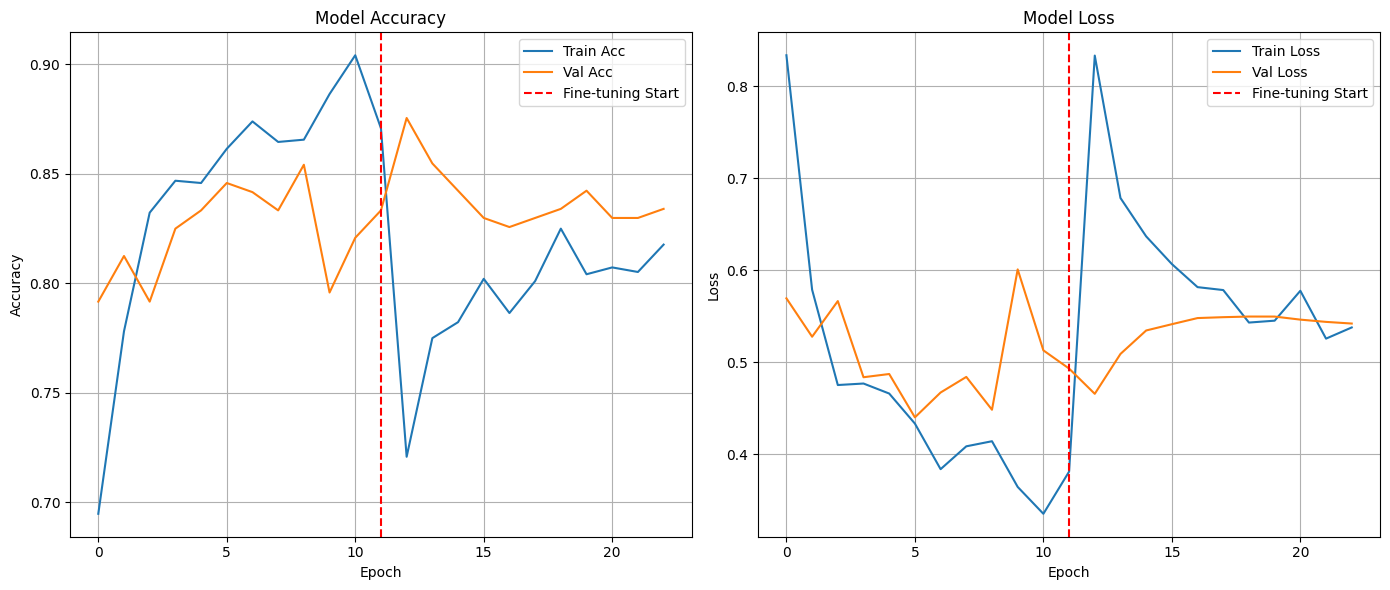

In [10]:

# ===========================================
# 📊 PLOT TRAINING CURVES
# ===========================================
def plot_history(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs_stage1 = len(history1.history['accuracy'])

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.axvline(epochs_stage1 - 1, color='red', linestyle='--', label='Fine-tuning Start')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.axvline(epochs_stage1 - 1, color='red', linestyle='--', label='Fine-tuning Start')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(DATA_PATH, 'training_curves.png'))
    plt.show()

print("\n📈 Generating training history plots...")
plot_history(history_stage1, history_stage2)

📥 Loading best fine-tuned model for evaluation...

🔍 Generating classification report and confusion matrix...
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step

Classification Report:
              precision    recall  f1-score   support

    wrinkles       0.89      0.93      0.91        60
  dark spots       0.97      0.92      0.94        61
  puffy eyes       0.82      0.82      0.82        60
  clear skin       0.83      0.83      0.83        60

    accuracy                           0.88       241
   macro avg       0.88      0.88      0.88       241
weighted avg       0.88      0.88      0.88       241



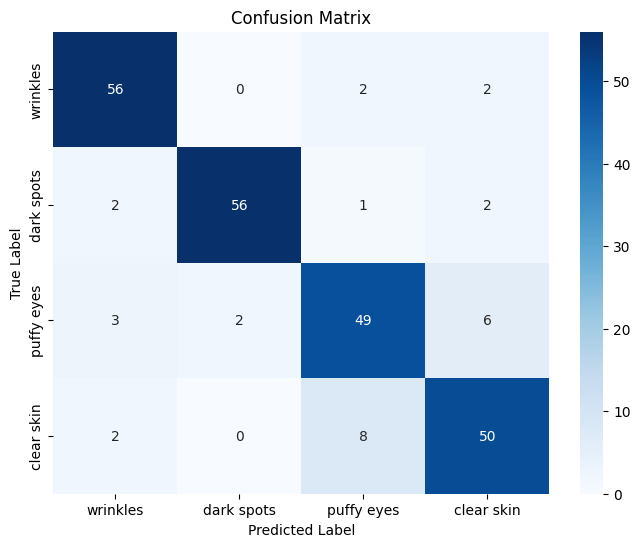


🎯 --- Model Training and Evaluation Complete ---


In [11]:
# 📉 CONFUSION MATRIX & CLASSIFICATION REPORT
# ===========================================
def plot_confusion_matrix(model, x_val, y_val_one_hot, class_names):
    print("\n🔍 Generating classification report and confusion matrix...")
    y_pred = model.predict(x_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_one_hot, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(DATA_PATH, 'confusion_matrix.png'))
    plt.show()

print("📥 Loading best fine-tuned model for evaluation...")
model.load_weights(MODEL_PATH)
plot_confusion_matrix(model, X_val, y_val, CLASSES)

print("\n🎯 --- Model Training and Evaluation Complete ---")


In [12]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive # Import drive for remounting
import shutil # Import shutil for file operations

# --- Configuration (Ensure consistency) ---
DRIVE_PATH = '/content/drive' # Standardize DRIVE_PATH to actual mount point
MODEL_OUTPUT_DIR = os.path.join(DRIVE_PATH, 'MyDrive/AI Facial Skin Aging Detection/output/models')
FINAL_DRIVE_MODEL_PATH = os.path.join(MODEL_OUTPUT_DIR, 'extreme_finetune_best_weights.weights.h5') # The final destination on Drive

# Local path for checkpointing during training to avoid Drive connection issues
LOCAL_CHECKPOINT_DIR = '/content/colab_model_checkpoints'
LOCAL_SAVE_PATH = os.path.join(LOCAL_CHECKPOINT_DIR, 'extreme_finetune_best_weights.weights.h5')

# --- Hyperparameters for Extreme Fine-Tuning ---
# Lower the LR to prevent corruption of weights when ALL layers are unfrozen
EXTREME_FINE_TUNE_LR = 1e-6
EXTREME_EPOCHS = 15 # Train for a few more epochs to adjust globally
PATIENCE = 5 # Decrease patience to restore best weights faster if loss spikes

# --- Ensure Callbacks are updated ---
# Redefine Callbacks to handle potential IndexError and set new monitoring
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=LOCAL_SAVE_PATH, # Save to local path during training
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True, # <--- Critical change: save only weights
        verbose=1
    )
]

# --- Force remount Google Drive ---
print("Attempting to force remount Google Drive...")
drive.mount(DRIVE_PATH, force_remount=True)
print("Google Drive remounted.")

# Ensure output directories exist
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True) # Ensure Drive output dir exists for final copy
os.makedirs(LOCAL_CHECKPOINT_DIR, exist_ok=True) # Ensure local checkpoint dir exists
print(f"Model output directory set to: {MODEL_OUTPUT_DIR}")
print(f"Local checkpoint directory set to: {LOCAL_CHECKPOINT_DIR}")

# Re-initialize model and load best weights from previous stage for robustness
# MODEL_PATH is '/content/drive/MyDrive/DATASET/final_efficientnet_model1.h5' as per previous cells.
print("Re-initializing model and loading best weights from Stage 2...")
model, base_model = build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)
# Load the best model from Stage 2 fine-tuning into this newly built model
# Assuming MODEL_PATH holds the path to 'final_efficientnet_model1.h5' from the CONFIG section of previous cells.
model.load_weights(MODEL_PATH)
print("✅ Model re-initialized with best weights from Stage 2.")

# ----------------------------------------------------
#               PHASE III: EXTREME FINE-TUNING
# ----------------------------------------------------
print("\n--- PHASE III: EXTREME FINE-TUNING (Unfreezing ALL Layers) ---")

# 1. Unfreeze ALL layers of the base model
base_model.trainable = True
# No need for a for-loop; all layers are now trainable

# 2. Recompile with the extremely low learning rate
model.compile(
    optimizer=Adam(learning_rate=EXTREME_FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Retrain
# Start training from where the last successful stage left off
if history_stage1.epoch:
    initial_epoch = history_stage1.epoch[-1] + 1
else:
    initial_epoch = 0

history_extreme = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_val / 255.0, y_val), # Ensure X_val is normalized here
    epochs=initial_epoch + EXTREME_EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    verbose=1
)

print(f"\nTraining complete. Best model weights temporarily saved to: {LOCAL_SAVE_PATH}")

# --- Copy best weights to Google Drive ---
if os.path.exists(LOCAL_SAVE_PATH):
    shutil.copy(LOCAL_SAVE_PATH, FINAL_DRIVE_MODEL_PATH)
    print(f"✅ Best weights copied to Google Drive: {FINAL_DRIVE_MODEL_PATH}")
else:
    print(f"❌ Could not find best weights at {LOCAL_SAVE_PATH} to copy to Drive.")

# Rebuild the model architecture and load the best weights from Drive
# This step is redundant if EarlyStopping(restore_best_weights=True) already did its job
# However, to be absolutely sure the final `model` variable reflects the saved best weights:
print("Ensuring the model holds the very best weights from Extreme Fine-Tuning...")
# Reload the model weights from the final saved path (which was copied to Drive)
# Assuming the current 'model' architecture is still correct.
model.load_weights(FINAL_DRIVE_MODEL_PATH)
print("✅ Model successfully loaded with best weights from Extreme Fine-Tuning.")

Attempting to force remount Google Drive...
Mounted at /content/drive
Google Drive remounted.
Model output directory set to: /content/drive/MyDrive/AI Facial Skin Aging Detection/output/models
Local checkpoint directory set to: /content/colab_model_checkpoints
Re-initializing model and loading best weights from Stage 2...
✅ Model re-initialized with best weights from Stage 2.

--- PHASE III: EXTREME FINE-TUNING (Unfreezing ALL Layers) ---
Epoch 13/27
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4908 - loss: 1.4513
Epoch 13: val_accuracy improved from -inf to 0.24896, saving model to /content/colab_model_checkpoints/extreme_finetune_best_weights.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 346s 5s/step - accuracy: 0.4913 - loss: 1.4503 - val_accuracy: 0.2490 - val_loss: 1.4916 - learning_rate: 1.0000e-06
Epoch 14/27
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5993 - loss: 1.2355
Epoch 14: val_accuracy improved from 0.24896 to 0.25311, saving model to /content/colab_model_checkpo

## Testing




✅ Model loaded successfully!


Saving 50.jpg to 50.jpg
Uploaded file: 50.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


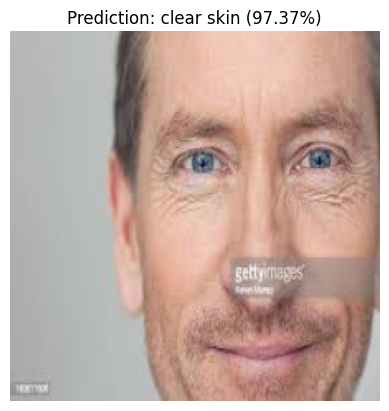

✅ Predicted class: clear skin
Confidence: 97.37%


In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files # Added import for files

# --- Define Classes ---
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']

# --- Load your fine-tuned model ---
MODEL_PATH = '/content/drive/MyDrive/DATASET/final_efficientnet_model1.h5' # Changed to .h5
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

def predict_local_image(image_path):
    """Predict the class for a local image file."""
    try:
        # Load and preprocess image
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize((224, 224))
        img_array = np.expand_dims(np.array(img_resized).astype('float32'), axis=0)

        # Preprocess for EfficientNet
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        img_preprocessed = preprocess_input(img_array)

        # Predict
        preds = model.predict(img_preprocessed)
        predicted_class = CLASSES[np.argmax(preds)]
        confidence = np.max(preds) * 100

        # Display
        plt.imshow(img_resized)
        plt.axis("off")
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")

    except Exception as e:
        print(f"❌ Error processing image: {e}")

# --- Execution Example ---
uploaded = files.upload()

if uploaded:
    # Get the filename from the uploaded dictionary
    image_filename = next(iter(uploaded))
    print(f"Uploaded file: {image_filename}")
    predict_local_image(image_filename) # Call the correct function with the filename
else:
    print("No file uploaded. Please upload an image to predict.")


✅ Model loaded successfully!


Saving 6.jpg to 6.jpg
Uploaded file: 6.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


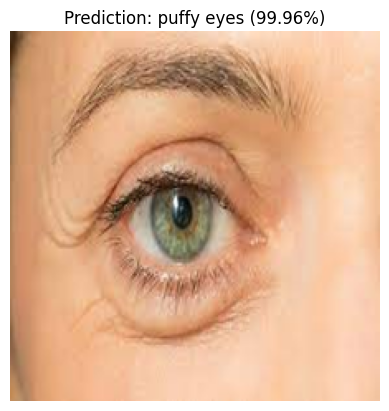

✅ Predicted class: puffy eyes
Confidence: 99.96%


In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files # Added import for files

# --- Define Classes ---
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']

# --- Load your fine-tuned model ---
MODEL_PATH = '/content/drive/MyDrive/DATASET/final_efficientnet_model1.h5' # Changed to .h5
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

def predict_local_image(image_path):
    """Predict the class for a local image file."""
    try:
        # Load and preprocess image
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize((224, 224))
        img_array = np.expand_dims(np.array(img_resized).astype('float32'), axis=0)

        # Preprocess for EfficientNet
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        img_preprocessed = preprocess_input(img_array)

        # Predict
        preds = model.predict(img_preprocessed)
        predicted_class = CLASSES[np.argmax(preds)]
        confidence = np.max(preds) * 100

        # Display
        plt.imshow(img_resized)
        plt.axis("off")
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")

    except Exception as e:
        print(f"❌ Error processing image: {e}")

# --- Execution Example ---
uploaded = files.upload()

if uploaded:
    # Get the filename from the uploaded dictionary
    image_filename = next(iter(uploaded))
    print(f"Uploaded file: {image_filename}")
    predict_local_image(image_filename) # Call the correct function with the filename
else:
    print("No file uploaded. Please upload an image to predict.")

Mounting Google Drive...
Mounted at /content/gdrive

Looking for model at: /content/gdrive/MyDrive/final_efficientnet_model.h5


Model loaded successfully.

Upload an image file (use the browse dialog). It will be analyzed immediately.


Saving 1c5e1b2b-2896-45a9-a1a0-cc05addc49db.jpg to 1c5e1b2b-2896-45a9-a1a0-cc05addc49db.jpg

File uploaded: 1c5e1b2b-2896-45a9-a1a0-cc05addc49db.jpg

--- Prediction result ---
Preprocessing chosen: raw(0..255)
Top prediction : dark spots (94.96%)

All class scores:
 - wrinkles    :   0.94%
 - dark spots  :  94.96%
 - puffy eyes  :   1.87%
 - clear skin  :   2.24%


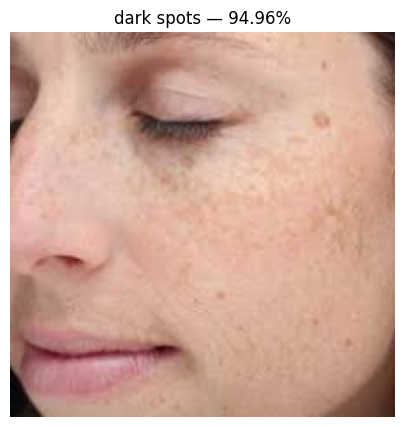

Saved a copy of the analyzed image to: /content/gdrive/MyDrive/predictions/pred_1c5e1b2b-2896-45a9-a1a0-cc05addc49db.jpg


In [17]:
import os, sys, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive, files
import tensorflow as tf
from tensorflow.keras.models import load_model

# ---------- CONFIG ----------
DRIVE_MOUNT_POINT = "/content/gdrive"
# change this to where your model is stored in Drive
MODEL_DRIVE_PATH = "MyDrive/final_efficientnet_model.h5"
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']   # make sure this matches your model's order
IMG_SIZE = 224

# ---------- mount drive ----------
print("Mounting Google Drive...")
drive.mount(DRIVE_MOUNT_POINT, force_remount=False)
MODEL_PATH = os.path.join(DRIVE_MOUNT_POINT, MODEL_DRIVE_PATH)

# ---------- load model ----------
print(f"\nLooking for model at: {MODEL_PATH}")
if not os.path.exists(MODEL_PATH):
    print("Model file not found. Check MODEL_DRIVE_PATH and that Drive is mounted correctly.")
    model = None
else:
    try:
        model = load_model(MODEL_PATH)
        print("Model loaded successfully.")
    except Exception as e:
        model = None
        print("Failed to load model. Error:")
        print(e)

# ---------- helper functions ----------
def read_image_local(path, target_size=(IMG_SIZE, IMG_SIZE)):
    """Read BGR image using OpenCV, return RGB uint8 and resized RGB float32 copy."""
    bgr = cv2.imdecode(np.fromfile(str(path), dtype=np.uint8), cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"OpenCV cannot read file: {path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb, target_size, interpolation=cv2.INTER_AREA)
    return rgb, resized.astype("float32")

def preprocess_try_both(img_uint8):
    """
    img_uint8 : HxWx3 uint8 (0..255)
    Returns two candidate batches:
      - raw_batch : dtype float32, values 0..255
      - scaled_batch: dtype float32, values 0..1
    """
    raw = img_uint8.astype("float32")
    scaled = raw / 255.0
    # add batch dimension
    return np.expand_dims(raw, axis=0), np.expand_dims(scaled, axis=0)

def choose_best_preproc(model, raw_batch, scaled_batch):
    """Run both through model, return (best_batch, best_preds, label, confidence, which)"""
    preds_raw = model.predict(raw_batch, verbose=0)
    preds_scaled = model.predict(scaled_batch, verbose=0)

    top_raw = preds_raw[0].max()
    top_scaled = preds_scaled[0].max()

    if top_scaled >= top_raw:
        return scaled_batch, preds_scaled[0], np.argmax(preds_scaled[0]), top_scaled, "scaled(0..1)"
    else:
        return raw_batch, preds_raw[0], np.argmax(preds_raw[0]), top_raw, "raw(0..255)"

def pretty_print_predictions(preds, classes):
    for i, c in enumerate(classes):
        print(f" - {c:12s}: {preds[i]*100:6.2f}%")

def show_image_for_display(img_uint8, title=None):
    plt.figure(figsize=(5,5))
    plt.imshow(img_uint8.astype("uint8")/255.0)
    if title:
        plt.title(title, fontsize=12)
    plt.axis("off")
    plt.show()

# ---------- main interactive flow ----------
if model is None:
    print("\nNo model available. Fix the MODEL_DRIVE_PATH and re-run.")
else:
    print("\nUpload an image file (use the browse dialog). It will be analyzed immediately.")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Exiting.")
    else:
        fname = next(iter(uploaded.keys()))
        print(f"\nFile uploaded: {fname}")
        try:
            orig_rgb, resized = read_image_local(fname, target_size=(IMG_SIZE, IMG_SIZE))
        except Exception as e:
            print("Failed to read uploaded image:", e)
            # try reading from the temp path instead (Colab stores uploads in working dir)
            try:
                orig_rgb, resized = read_image_local(os.path.join("/content", fname))
            except Exception as e2:
                print("Still failed:", e2)
                raise

        raw_batch, scaled_batch = preprocess_try_both(resized)
        best_batch, best_preds, best_idx, best_conf, which = choose_best_preproc(model, raw_batch, scaled_batch)

        top_label = CLASSES[best_idx]
        top_conf_pct = float(best_conf * 100.0)

        print("\n--- Prediction result ---")
        print(f"Preprocessing chosen: {which}")
        print(f"Top prediction : {top_label} ({top_conf_pct:5.2f}%)")
        print("\nAll class scores:")
        pretty_print_predictions(best_preds, CLASSES)

        # Show image with title
        show_image_for_display(resized, title=f"{top_label} — {top_conf_pct:5.2f}%")

        # Optional: save results to Drive folder next to model
        try:
            out_dir = os.path.join(os.path.dirname(MODEL_PATH), "predictions")
            os.makedirs(out_dir, exist_ok=True)
            out_fname = os.path.join(out_dir, f"pred_{Path(fname).stem}.jpg")
            # save the displayed resized RGB image as a JPEG
            cv2.imencode('.jpg', cv2.cvtColor(resized.astype('uint8'), cv2.COLOR_RGB2BGR))[1].tofile(out_fname)
            print(f"Saved a copy of the analyzed image to: {out_fname}")
        except Exception:
            pass


In [18]:
import tensorflow as tf
import os
from google.colab import drive

MODEL_PATH = '/content/drive/MyDrive/DATASET/final_efficientnet_model1.h5'

print("Attempting to force remount Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("Google Drive remounted.")

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f"✅ Model loaded successfully from: {MODEL_PATH}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Please ensure the model path is correct and Google Drive is properly mounted.")
    model = None

Attempting to force remount Google Drive...
Mounted at /content/drive
Google Drive remounted.


✅ Model loaded successfully from: /content/drive/MyDrive/DATASET/final_efficientnet_model1.h5


Attempting to force remount Google Drive...
Mounted at /content/drive
Google Drive remounted.
✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


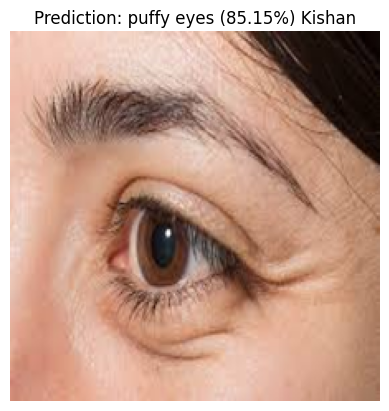

✅ Predicted class: puffy eyes
Confidence: 85.15%


In [19]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from google.colab import drive # Added import for drive

# --- Define Classes ---
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']

# --- Load your fine-tuned model ---
MODEL_PATH = '/content/drive/MyDrive/DATASET/final_efficientnet_model1.keras' # Changed to .keras

# Force remount Google Drive to ensure stable connection
print("Attempting to force remount Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("Google Drive remounted.")

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model even after remount: {e}")
    model = None # Ensure model is None if loading fails

# --- Helper Function ---
def predict_image_from_url(img_url):
    """
    Takes an image URL, downloads it, preprocesses it, and predicts the class.
    """
    if model is None:
        print("🛑 Model not loaded, cannot make predictions.")
        return

    try:
        # Read the image from URL
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img_resized = img.resize((224, 224))

        # Convert to array
        img_array = np.array(img_resized).astype('float32')
        img_array = np.expand_dims(img_array, axis=0)

        # EfficientNet preprocessing
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        img_preprocessed = preprocess_input(img_array)

        # Predict
        preds = model.predict(img_preprocessed)
        predicted_class = CLASSES[np.argmax(preds)]
        confidence = np.max(preds) * 100

        # Display result
        plt.imshow(img_resized)
        plt.axis("off")
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%) Kishan")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")

# --- 🔽 Example: Try with any Google Image URL ---
test_image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRiBOlyrArihympImP_MqyJeQAqjQyagDeTsA&s.jpg"
predict_image_from_url(test_image_url)

✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


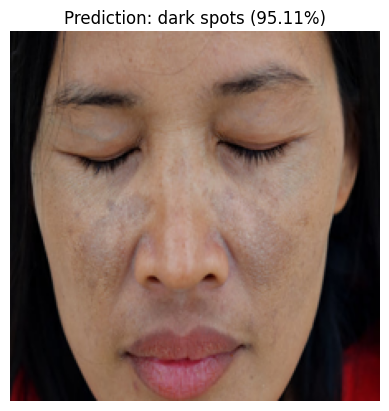

✅ Predicted class: dark spots
Confidence: 95.11%


In [20]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

# --- Define Classes ---
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']

# --- Load your fine-tuned model ---
MODEL_PATH = '/content/drive/MyDrive/DATASET/final_efficientnet_model1.keras' # Changed to .keras
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

# --- Helper Function ---
def predict_image_from_url(img_url):
    """
    Takes an image URL, downloads it, preprocesses it, and predicts the class.
    """
    try:
        # Read the image from URL
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img_resized = img.resize((224, 224))

        # Convert to array
        img_array = np.array(img_resized).astype('float32')
        img_array = np.expand_dims(img_array, axis=0)

        # EfficientNet preprocessing
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        img_preprocessed = preprocess_input(img_array)

        # Predict
        preds = model.predict(img_preprocessed)
        predicted_class = CLASSES[np.argmax(preds)]
        confidence = np.max(preds) * 100

        # Display result
        plt.imshow(img_resized)
        plt.axis("off")
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")

# --- 🔽 Example: Try with any Google Image URL ---
test_image_url = "https://cdn.shopify.com/s/files/1/0495/8774/9021/files/shutterstock_1540815983_480x480.jpg?v=1625412092.jpg"
predict_image_from_url(test_image_url)

TESTING WITH 75 SAMPLES

In [21]:
TEST_DIR = '/content/drive/MyDrive/DATASET/TEST_SAMPLES'
print(f"Test directory set to: {TEST_DIR}")

# Load images and labels
X_test_raw, y_test_labels, test_label_names = load_images(TEST_DIR, CLASSES)

# Convert to float32 (already handled by load_images, but ensure if not)
X_test_raw = X_test_raw.astype('float32')

# One-hot encode the labels
y_test_encoded = to_categorical(y_test_labels, num_classes=len(CLASSES))

print(f"\nTest Images (X_test_raw) shape: {X_test_raw.shape}")
print(f"Test Labels (y_test_encoded) shape: {y_test_encoded.shape} (One-Hot Encoded)")

Test directory set to: /content/drive/MyDrive/DATASET/TEST_SAMPLES
Starting image loading and resizing...
Processing class: wrinkles
Processing class: dark spots
Processing class: puffy eyes
Processing class: clear skin

Test Images (X_test_raw) shape: (284, 224, 224, 3)
Test Labels (y_test_encoded) shape: (284, 4) (One-Hot Encoded)


In [22]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Assuming CLASSES and IMG_SIZE are already defined in a previous cell and accessible
# CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']
# IMG_SIZE = 224

def load_images(data_dir, classes):
    """Loads images, resizes, and converts BGR to RGB."""
    data = []
    labels = []
    label_names_for_plot = []

    print("Starting image loading and resizing...")
    for idx, label in enumerate(classes):
        path = os.path.join(data_dir, label)
        if not os.path.exists(path):
            print(f" ERROR: Path not found: {path}")
            continue

        print(f"Processing class: {label}")
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Convert BGR (OpenCV default) to RGB (Matplotlib/TF default)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                data.append(img.astype('float32'))  # Keep [0,255] range
                labels.append(idx)
                label_names_for_plot.append(label)
            else:
                print(f" Warning: Could not read image {img_name}")

    return np.array(data), np.array(labels), label_names_for_plot

TEST_DIR = '/content/drive/MyDrive/DATASET/TEST_SAMPLES'
print(f"Test directory set to: {TEST_DIR}")

# Load images and labels
X_test_raw, y_test_labels, test_label_names = load_images(TEST_DIR, CLASSES)

# Convert to float32 (already handled by load_images, but ensure if not)
X_test_raw = X_test_raw.astype('float32')

# One-hot encode the labels
y_test_encoded = to_categorical(y_test_labels, num_classes=len(CLASSES))

print(f"\nTest Images (X_test_raw) shape: {X_test_raw.shape}")
print(f"Test Labels (y_test_encoded) shape: {y_test_encoded.shape} (One-Hot Encoded)")

Test directory set to: /content/drive/MyDrive/DATASET/TEST_SAMPLES
Starting image loading and resizing...
Processing class: wrinkles
Processing class: dark spots
Processing class: puffy eyes
Processing class: clear skin

Test Images (X_test_raw) shape: (284, 224, 224, 3)
Test Labels (y_test_encoded) shape: (284, 4) (One-Hot Encoded)


In [23]:
from tensorflow.keras.models import load_model

# Define the path to the best fine-tuned model
MODEL_PATH = '/content/drive/MyDrive/DATASET/final_efficientnet_model1.keras'

# Load the model
model = load_model(MODEL_PATH)
print(f"✅ Model loaded successfully from: {MODEL_PATH}")

✅ Model loaded successfully from: /content/drive/MyDrive/DATASET/final_efficientnet_model1.keras


In [24]:
print("Making predictions on the test dataset...")

# Make predictions on the preprocessed test data
predictions = model.predict(X_test_raw)

# Get predicted class indices
y_pred_indices = np.argmax(predictions, axis=1)

# Get true class indices from one-hot encoded labels
y_true_indices = np.argmax(y_test_encoded, axis=1)

print("✅ Predictions generated.")
print(f"Shape of predictions: {predictions.shape}")
print(f"Shape of predicted class indices: {y_pred_indices.shape}")
print(f"Shape of true class indices: {y_true_indices.shape}")

Making predictions on the test dataset...
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step
✅ Predictions generated.
Shape of predictions: (284, 4)
Shape of predicted class indices: (284,)
Shape of true class indices: (284,)



🔍 Generating classification report and confusion matrix...

Classification Report:
              precision    recall  f1-score   support

    wrinkles       0.00      0.00      0.00        75
  dark spots       0.90      0.93      0.92        75
  puffy eyes       0.69      0.93      0.79        75
  clear skin       0.04      0.05      0.05        59

    accuracy                           0.50       284
   macro avg       0.41      0.48      0.44       284
weighted avg       0.43      0.50      0.46       284



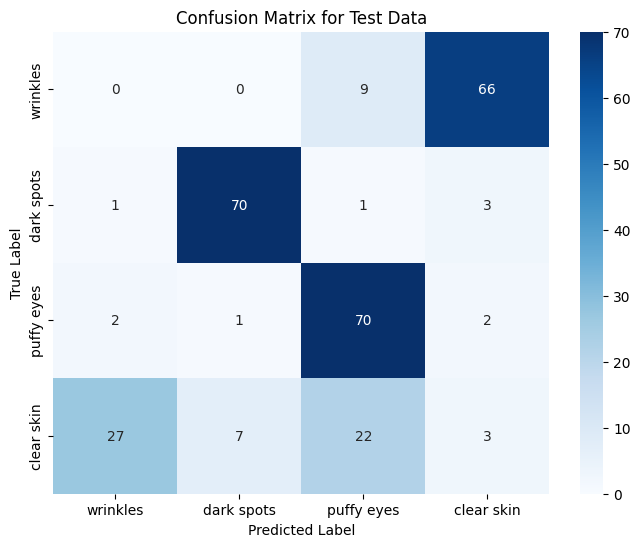


✅ Overall Test Accuracy: 50.35%

✅ Test Evaluation Complete.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("\n🔍 Generating classification report and confusion matrix...")

# Generate classification report
report = classification_report(y_true_indices, y_pred_indices, target_names=CLASSES)
print("\nClassification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true_indices, y_pred_indices)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix for Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/content/drive/MyDrive/DATASET/test_confusion_matrix.png')
plt.show()

# Calculate overall test accuracy
overall_test_accuracy = np.mean(y_true_indices == y_pred_indices) * 100
print(f"\n\u2705 Overall Test Accuracy: {overall_test_accuracy:.2f}%")
print("\n\u2705 Test Evaluation Complete.")

Displaying up to 4 correct predictions for each class...

Class: wrinkles (True Label: 0)
Found 0 correct predictions.

Class: dark spots (True Label: 1)
Found 70 correct predictions.

Class: puffy eyes (True Label: 2)
Found 70 correct predictions.

Class: clear skin (True Label: 3)
Found 3 correct predictions.


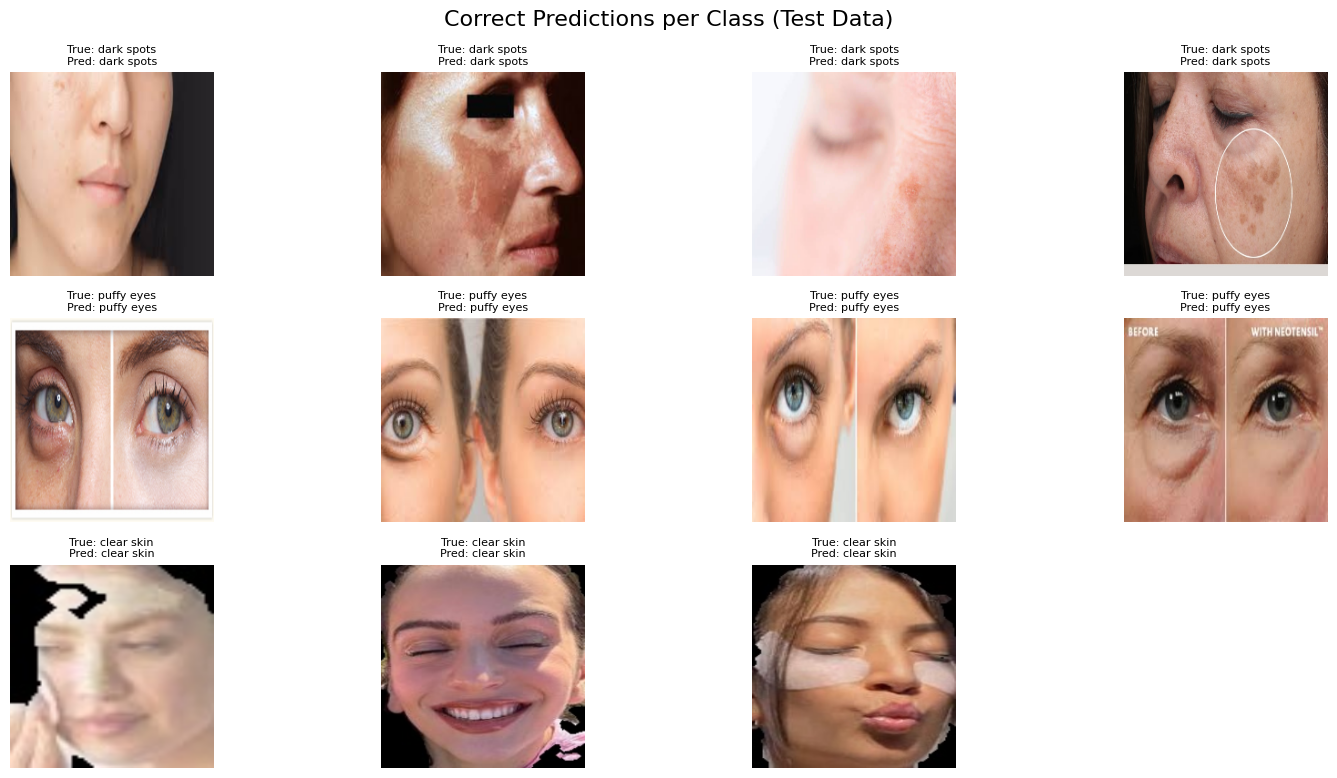


Visualisation complete.


In [26]:
import matplotlib.pyplot as plt
import numpy as np

num_display = 4

print(f"Displaying up to {num_display} correct predictions for each class...")

plt.figure(figsize=(15, 10))
plot_idx = 1

for class_idx, class_name in enumerate(CLASSES):

    correct_predictions_for_class_indices = np.where(
        (y_true_indices == class_idx) & (y_pred_indices == class_idx)
    )[0]

    print(f"\nClass: {class_name} (True Label: {class_idx})")
    print(f"Found {len(correct_predictions_for_class_indices)} correct predictions.")


    for i in range(min(num_display, len(correct_predictions_for_class_indices))):
        sample_idx = correct_predictions_for_class_indices[i]
        image_to_display = X_test_raw[sample_idx]

        plt.subplot(len(CLASSES), num_display, plot_idx)
        plt.imshow(image_to_display.astype('uint8'))
        plt.title(f"True: {CLASSES[y_true_indices[sample_idx]]}\nPred: {CLASSES[y_pred_indices[sample_idx]]}", fontsize=8)
        plt.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.suptitle('Correct Predictions per Class (Test Data)', y=1.02, fontsize=16)
plt.show()
print("\nVisualisation complete.")

Displaying misclassified images...

True Class: wrinkles (Index: 0)
Found 75 misclassified images.


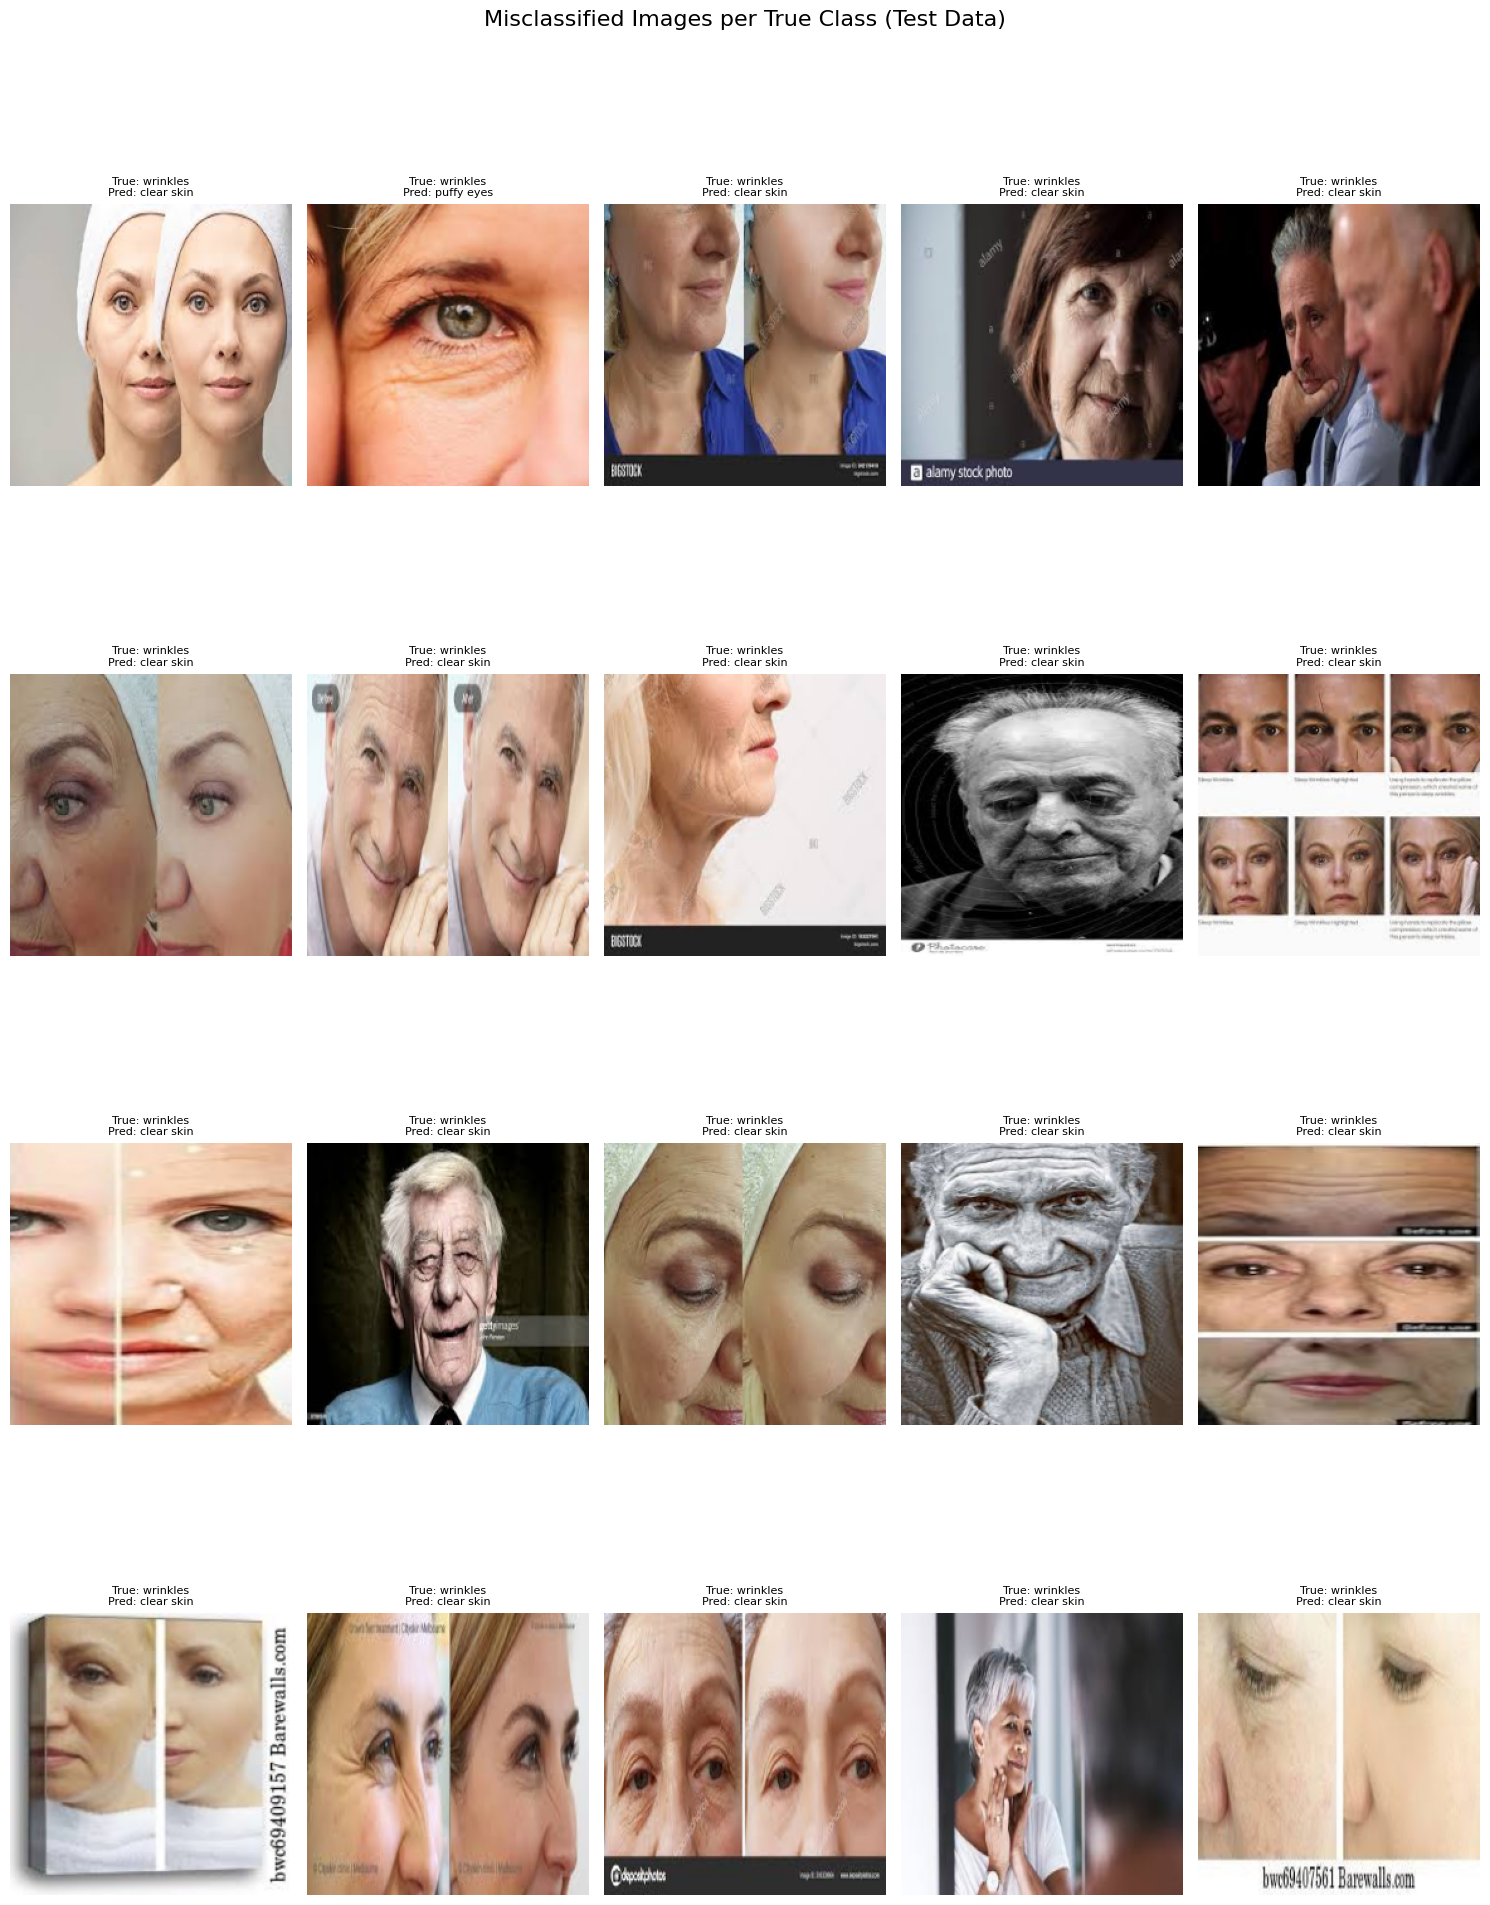


Misclassified images visualization complete.


In [27]:
import matplotlib.pyplot as plt
import numpy as np

print("Displaying misclassified images...")

plt.figure(figsize=(15, 20))
plot_idx = 1

num_cols = 5 # Number of columns for displaying images
max_total_plots = len(CLASSES) * num_cols # Calculate total available subplot positions

for class_idx, class_name in enumerate(CLASSES):

    misclassified_indices_for_class = np.where(
        (y_true_indices == class_idx) & (y_pred_indices != class_idx)
    )[0]

    print(f"\nTrue Class: {class_name} (Index: {class_idx})")
    print(f"Found {len(misclassified_indices_for_class)} misclassified images.")

    for i, sample_idx in enumerate(misclassified_indices_for_class):
        if plot_idx > max_total_plots:
            # If we've filled the grid, stop plotting further images
            break

        image_to_display = X_test_raw[sample_idx]

        # Adjusting subplot layout for clarity
        plt.subplot(len(CLASSES), num_cols, plot_idx)
        plt.imshow(image_to_display.astype('uint8'))
        plt.title(f"True: {CLASSES[y_true_indices[sample_idx]]}\nPred: {CLASSES[y_pred_indices[sample_idx]]}", fontsize=8)
        plt.axis('off')
        plot_idx += 1

    if plot_idx > max_total_plots: # Also break the outer loop if the grid is full
        break

# Adjust overall layout for all plots
plt.tight_layout()
plt.suptitle('Misclassified Images per True Class (Test Data)', y=1.02, fontsize=16)
plt.show()
print("\nMisclassified images visualization complete.")

# MODULE 4: FACE DETECTION AND PREDICTION PIPELINE

In [28]:
from google.colab import drive
import os

# Define the drive path
DRIVE_PATH = '/content/gdrive'

# Check if the drive is already mounted and try to mount if not
if not os.path.exists(os.path.join(DRIVE_PATH, 'MyDrive')):
    print("Drive mounting required...")
    # This will prompt you to click a link and authorize access
    drive.mount(DRIVE_PATH)
    print("✅ Google Drive re-mounted successfully.")
else:
    print("✅ Google Drive connection is stable.")

Drive mounting required...
Mounted at /content/gdrive
✅ Google Drive re-mounted successfully.


✅ Model loaded successfully for pipeline.
✅ Haar Cascade loaded successfully.

--- Running the Prediction Pipeline (Module 4) ---

--- Testing with local file: /content/gdrive/MyDrive/DATASET/TEST_SAMPLES/images.jpeg ---


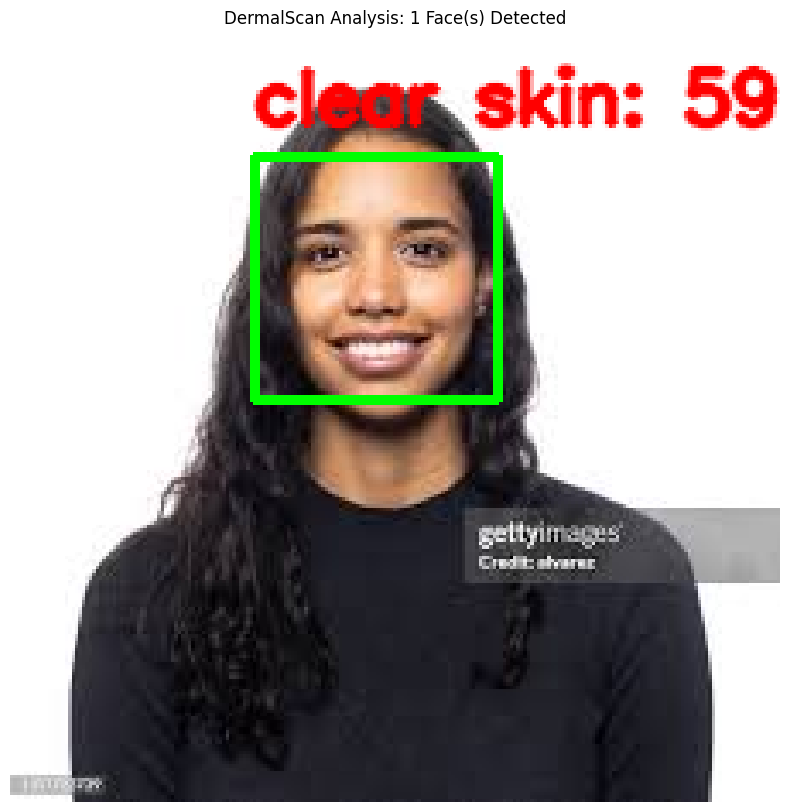

✅ Analysis Complete. Results displayed for 1 face(s).


In [32]:

MODEL_PATH = '/content/gdrive/MyDrive/DATASET/final_efficientnet_model1.keras'
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']
IMG_SIZE = 224
NUM_CLASSES = len(CLASSES)

# --- Imports for this module ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
from io import BytesIO
from google.colab.patches import cv2_imshow # Specific for Colab
import os

# --- 1. Load Model (Re-check just in case) ---
try:
    # Load the best model, ensuring it can handle the custom objects/layers if any
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✅ Model loaded successfully for pipeline.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    model = None

# --- 2. Load Haar Cascade Classifier ---
# Download the Haar Cascade XML file (a standard OpenCV asset for frontal face detection)
HAAR_CASCADE_URL = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
CASCADE_FILENAME = 'haarcascade_frontalface_default.xml'

try:
    # Use requests to download the file directly in Colab
    r = requests.get(HAAR_CASCADE_URL)
    with open(CASCADE_FILENAME, 'wb') as f:
        f.write(r.content)

    # Load the classifier
    face_cascade = cv2.CascadeClassifier(CASCADE_FILENAME)
    if face_cascade.empty():
        raise IOError("Could not load Haar Cascade XML.")
    print("✅ Haar Cascade loaded successfully.")
except Exception as e:
    print(f"❌ Error loading Haar Cascade: {e}")
    face_cascade = None


# --- 3. Core Prediction Function with Face Detection ---
def predict_with_face_detection(image_path_or_url):
    """
    Performs face detection, crops the face, and runs the classification model.
    """
    if model is None or face_cascade is None:
        print("🛑 Pipeline aborted: Model or Cascade not initialized.")
        return

    # --- Image Loading ---
    try:
        # Handle both local file paths and URLs
        if image_path_or_url.startswith(('http', 'https')):
            response = requests.get(image_path_or_url)
            img_data = response.content
            img_np = np.frombuffer(img_data, np.uint8)
            img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
        else:
            img = cv2.imread(image_path_or_url)

        if img is None:
            raise FileNotFoundError(f"Image not found or could not be read: {image_path_or_url}")

        original_image = img.copy()
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        print(f"❌ Error reading image: {e}")
        return

    # --- Face Detection (Task 1) ---
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(
        gray_image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    if len(faces) == 0:
        print("⚠️ No faces detected in the image.")
        # Display the original image (optional)
        # cv2_imshow(original_image)
        return

    # --- Apply Model and Display Predictions (Tasks 2 & 3) ---
    for (x, y, w, h) in faces:
        # 1. Crop the face area with a slight border for context
        border = 20
        x1 = max(0, x - border)
        y1 = max(0, y - border)
        x2 = min(original_image.shape[1], x + w + border)
        y2 = min(original_image.shape[0], y + h + border)

        face_crop = original_image[y1:y2, x1:x2]

        # 2. Preprocess the cropped face (Resize and convert color space)
        face_resized = cv2.resize(face_crop, (IMG_SIZE, IMG_SIZE))

        # OpenCV reads as BGR, but your model was trained on data converted to RGB
        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)

        # Prepare for prediction: add batch dimension and preprocess input
        face_array = np.expand_dims(face_rgb.astype('float32'), axis=0)

        # EfficientNet's built-in preprocessing layer (scaling)
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        face_preprocessed = preprocess_input(face_array)

        # 3. Predict the skin condition
        preds = model.predict(face_preprocessed, verbose=0)

        # Get top prediction and confidence
        predicted_index = np.argmax(preds[0])
        predicted_class = CLASSES[predicted_index]
        confidence = preds[0][predicted_index] * 100

        box_color = (0, 255, 0) # Green BGR
        box_thickness = 2
        cv2.rectangle(original_image, (x, y), (x + w, y + h), box_color, box_thickness)

        # Create text label with prediction and percentage
        label = f"{predicted_class}: {confidence:.2f}%"

        # Add text label above the bounding box
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        font_thickness = 2
        text_color = (0, 0, 255) # Red BGR

        # Determine text position to place it above the box
        text_x = x
        text_y = y - 10 if y - 10 > 10 else y + h + 20

        cv2.putText(original_image, label, (text_x, text_y), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

    # Display the final image with results (Use matplotlib for better Colab compatibility)
    plt.figure(figsize=(10, 10))
    # Note: cv2_imshow uses BGR, but plt uses RGB. We must convert the final image back for plt.
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f"DermalScan Analysis: {len(faces)} Face(s) Detected")
    plt.axis('off')
    plt.show()

    print(f"✅ Analysis Complete. Results displayed for {len(faces)} face(s).")


TEST_IMAGE_PATH = os.path.join(DRIVE_PATH, 'MyDrive/DATASET/TEST_SAMPLES/images.jpeg')
print("\n--- Running the Prediction Pipeline (Module 4) ---")
print(f"\n--- Testing with local file: {TEST_IMAGE_PATH} ---")
predict_with_face_detection(TEST_IMAGE_PATH)


--- Running the Prediction Pipeline (Module 4) ---

--- Testing with local file: /content/gdrive/MyDrive/DATASET/TEST_SAMPLES/sample.jpeg ---


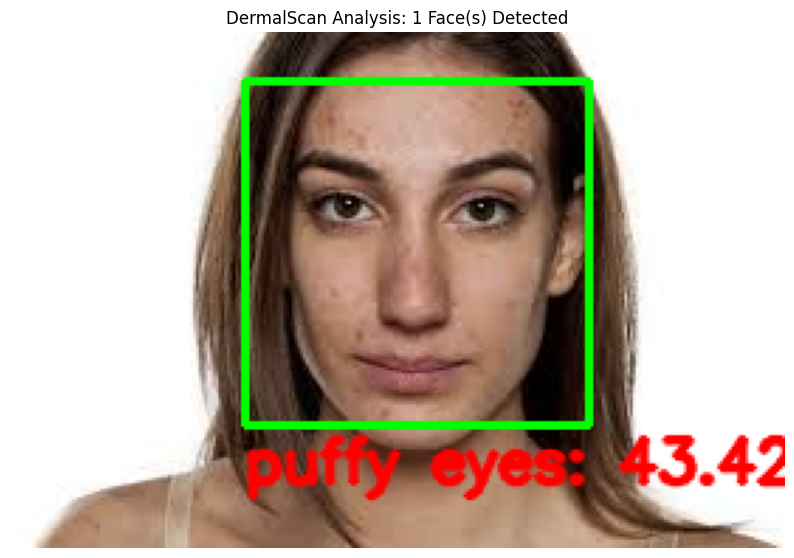

✅ Analysis Complete. Results displayed for 1 face(s).


In [34]:
TEST_IMAGE_PATH = os.path.join(DRIVE_PATH, 'MyDrive/DATASET/TEST_SAMPLES/sample.jpeg')
print("\n--- Running the Prediction Pipeline (Module 4) ---")
print(f"\n--- Testing with local file: {TEST_IMAGE_PATH} ---")
predict_with_face_detection(TEST_IMAGE_PATH)


--- Running the Prediction Pipeline (Module 4) ---

--- Testing with local file: /content/gdrive/MyDrive/DATASET/TEST_SAMPLES/puffy.jpeg ---


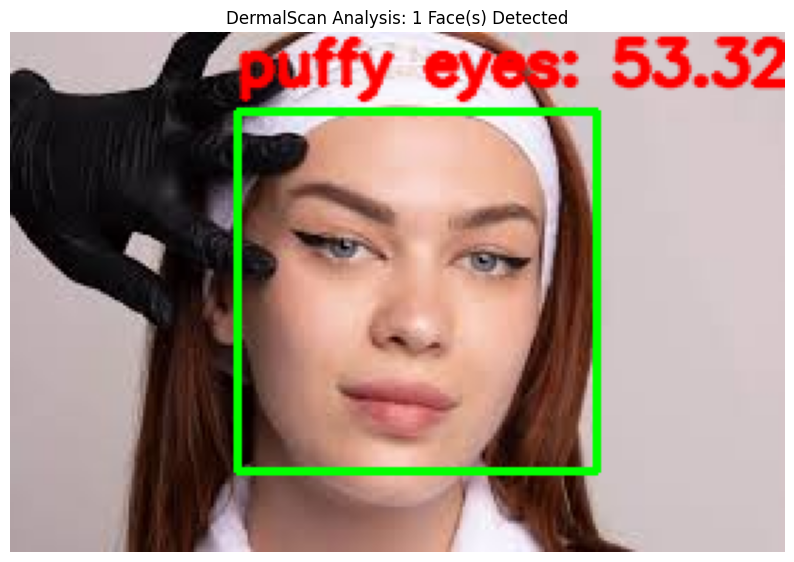

✅ Analysis Complete. Results displayed for 1 face(s).


In [35]:
TEST_IMAGE_PATH = os.path.join(DRIVE_PATH, 'MyDrive/DATASET/TEST_SAMPLES/puffy.jpeg')
print("\n--- Running the Prediction Pipeline (Module 4) ---")
print(f"\n--- Testing with local file: {TEST_IMAGE_PATH} ---")
predict_with_face_detection(TEST_IMAGE_PATH)